In [38]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt

# Fix random seed for reproducibility
rng = np.random.default_rng(seed=2024)


# Queueing simulation
## Exponential random draws

In [39]:
def exponential_rng(lam: float=1.0) -> float:
    """Generates exponential random numbers
    
    Parameters
    ==========
    lam : float
        The rate parameter, the inverse expectation of the distribution.
    
    Returns
    =======
    float
        Exponential random number with given rate.
    """
    return -np.log(rng.random()) / lam


## Define events

In [40]:

class EventType(Enum):
    """Types of event in the system"""
    SIMULATION_START = 0
    GENERATION = 1
    ARRIVAL = 2
    DEPARTURE = 3
    SIMULATION_END = 4

class Event(object):
    """Generic event in the scenario
    
    Parameters
    ==========
    type : EventType
        Type of the event
    time : float
        Type of occurence of the event
    """
    def __init__(self, type: EventType, time: float):
        self.__type = type
        self.__time = time

    @property
    def type(self) -> EventType:
        return self.__type

    @property
    def time(self) -> float:
        return self.__time

## Define scenario

In [41]:
class Scenario(object):
    """Road scenario
    
    Parameters
    ==========
    T : float
        Duration of the vehicle generation.
    t0 : float
        Free-flow travel time.
    lam : float
        Vehicle entry rate.
    mu : float
        Service rate.
    """
    def __init__(self, 
                 T: float = 50.0,
                 t0: float = 1.0,
                 lam: float = 1.0,
                 mu: float = 1.0,
                ):
        self.__T = T
        self.__t0 = t0
        self.__lam = lam
        self.__mu = mu
    
    @property
    def T(self) -> float:
        return self.__T

    @property
    def t0(self) -> float:
        return self.__t0

    @property
    def lam(self) -> float:
        return self.__lam

    @property
    def mu(self) -> float:
        return self.__mu

## Define simulation procedure

In [42]:
def simulate(scenario: Scenario) :
    """Implements the simulation procedure.
    
    Parameters
    ==========
    scenario : Scenario
        Road scenario.
    
    Returns
    =======
    times : list[float]
        Event times. 
    queues : list[int]
        Queue length over time. 
    """
    # Initialization of the simulation
    events: list[Event] = [Event(type=EventType.SIMULATION_START, time=0)]
    queue_length: list[int] = [0]
    current_time: float = 0.0
    simulation_end: bool = False
    
    # Simulation event timings (internal state)
    next_car_gen: float = np.inf
    next_car_arr: list[float] = [np.inf]
    next_car_dep: float = np.inf

    # Schedule the very-first car arrival
    next_car_gen = current_time + exponential_rng(lam=scenario.lam)

    # Run the simulation until the simulation is over
    while not simulation_end:
        # Process the closest event in time
        current_time = np.min([next_car_gen, np.min(next_car_arr), next_car_dep]) 

        # CAR GENERATION
        if current_time == next_car_gen:
            if current_time > scenario.T:
                # Do not generate any new car after time T
                next_car_gen = np.inf
            else:
                # Generate a car (and repeat the current queue size)
                events.append(Event(EventType.GENERATION, current_time))
                queue_length.append(queue_length[-1])
                # Schedule the new car's arrival in the queue
                arr_time = current_time + rng.uniform(low=0.0, high=scenario.t0)
                next_car_arr.append(arr_time)
                # Schedule the next car generation
                next_car_gen = current_time + exponential_rng(scenario.lam)

        # CAR ARRIVAL
        elif current_time == np.min([next_car_arr]):
            # Register the car arrival and increase the queue count
            events.append(Event(EventType.ARRIVAL, current_time))
            next_car_arr.remove(current_time)
            queue_length.append(queue_length[-1] + 1)
            # Schedule the next departure (if needed)
            if queue_length[-1] == 1:
                next_car_dep = current_time + exponential_rng(scenario.mu)
        
        # CAR DEPARTURE
        elif current_time == next_car_dep:
            # Register the car departure and decrease the queue count
            events.append(Event(EventType.DEPARTURE, current_time))
            queue_length.append(queue_length[-1] - 1)
            # Schedule the next departure (if needed)
            if queue_length[-1] == 0:
                next_car_dep = np.inf
            else:
                next_car_dep = current_time + exponential_rng(scenario.mu)

        # Stop the simulation if: no cars in queue & no cars on road & no cars to generate
        if queue_length[-1] == 0 and np.min(next_car_arr) == np.inf and next_car_gen == np.inf:
            simulation_end = True
            events.append(Event(EventType.SIMULATION_END, current_time))
            queue_length.append(0)
    
    # Get the list of timestamps of all events
    times = [event.time for event in events]
    assert len(times) == len(queue_length)

    return times, queue_length

## Run simulation

In [48]:
times, queues = simulate(Scenario())


## Repeat the simulation multiple times

In [49]:
D = 3
times_queues = [simulate(Scenario()) for d in range(D)]


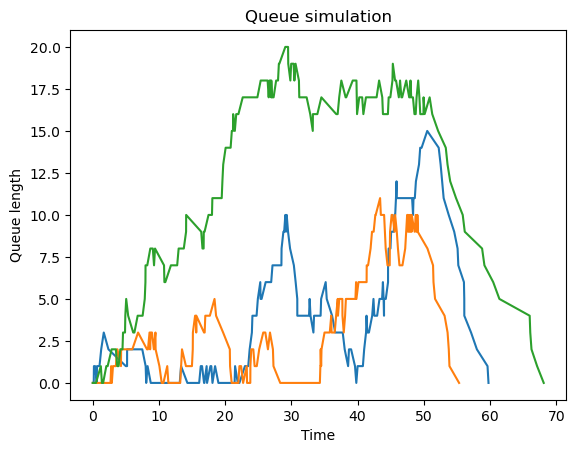

In [50]:
fig = plt.figure()
ax = plt.subplot(1,1,1)

for t, q in times_queues:
    ax.plot(t, q)
ax.set(title='Queue simulation',
       xlabel='Time',
       ylabel='Queue length')
fig.savefig('figure_queue_simulation.pdf', dpi=300)
plt.show()
